In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from fa2 import ForceAtlas2
import random
import numpy as np


In [26]:
def load_file(file_path):
#     data_path = "../../data/ground-truth/Sparse/n=200d=6"
    f = open(file_path)
    edge_list = []
    data_list = []
    for line in f.readlines():
        data_list.append(line.strip())
    num_nodes = int (data_list.pop(0)) #Pop out the number of nodes 

    for i in range(num_nodes+1,len(data_list)):
        edge_list.append(tuple([int(data_list[i].strip('\n').split(" ")[0]), int(data_list[i].strip('\n').split(" ")[1])]))
    return edge_list, num_nodes, file_path.split("/")[-1]

In [27]:
def store(pos_dict, edges_list, target_graph_path):
    with open(target_graph_path,"w+") as f:
        f.write(str(len(pos_dict)) + "\n")
        for num, pos in pos_dict.items():
            f.write(str(num) + " " + str(float(pos[0])) + " " + str(float(pos[1])) + "\n")
        f.write(str(len(edges_list)) + "\n")
        for edge in edges_list:
            f.write(str(edge[0]) + " " + str(edge[1]) + "\n")
        f.close()


In [28]:
def scale_coordinates(coords, new_range):
    """将坐标等比例放大，并调整范围适合给定的范围"""
    # 找到坐标的最小值和最大值
    min_coord = min(coords)
    max_coord = max(coords)

    # 将为负的坐标变为正
    if min_coord < 0:
        for i in range (len(coords)):
            coords[i] = coords[i] + min_coord * -1

    # 计算坐标的范围
    coord_range = max_coord - min_coord

    # 计算缩放比例
    if coord_range == 0:
        scale_factor = 1.0
    else:
        scale_factor = float(new_range) / coord_range

    # 缩放坐标
    scaled_coords = [int(round((c - min_coord) * scale_factor)) for c in coords]
    return scaled_coords


In [29]:
def pos_calculation(pos_dict, new_range=1000):
    node_x = []
    node_y = []
    for key, value in pos_dict.items():
        node_x.append(value[0])
        node_y.append(value[1])
    scaled_x = scale_coordinates(node_x, new_range)
    scaled_y = scale_coordinates(node_y, new_range)
    result_dict = {}
    for i in range(len(scaled_x)):
        result_dict[i] = [scaled_x[i], scaled_y[i]]
    return result_dict
    

In [30]:
def fr_nx(edges_list,type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define spring layout and draw graph
    pos_dict = nx.fruchterman_reingold_layout(G, k=0.3, iterations=100)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
            
    # Set edge weights and draw graph
    # nx.draw_networkx_edges(G, pos_dict, width=weights)

    return pos_dict

In [31]:
def kk_nx(edges_list, type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define Kamada-Kawai layout and draw graph
    pos_dict = nx.kamada_kawai_layout(G)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    # nx.draw_networkx_edges(G, pos_dict, width=weights)
    print(pos_dict)
    return pos_dict

In [32]:


# Define function to create graph
def jiggle_nx(edges_list, type,iterations=100, scale=1):
    
    # initialize the positions of the nodes randomly
    positions = np.random.rand(len(G), 2)
    
    # iterate over the number of iterations
    for i in range(iterations):
        # calculate the repulsive forces between nodes
        repulsive_forces = np.zeros_like(positions)
        for u, pos_u in enumerate(positions):
            for v, pos_v in enumerate(positions):
                if u != v:
                    diff = pos_u - pos_v
                    distance = np.sqrt(np.sum(diff ** 2))
                    if distance > 0:
                        repulsive_forces[u] += (diff / distance) / distance
        
        # calculate the attractive forces between adjacent nodes
        attractive_forces = np.zeros_like(positions)
        for u, v in G.edges():
            diff = positions[u-1] - positions[v-1]
            distance = np.sqrt(np.sum(diff ** 2))
            attractive_forces[u-1] -= diff * distance
            attractive_forces[v-1] += diff * distance
            
        # calculate the total force acting on each node
        total_forces = repulsive_forces + attractive_forces
        
        # update the positions of the nodes based on the total force
        positions += scale * total_forces
    
    # return the final positions of the nodes
    return positions




In [33]:
def jiggle_layout_sparse(G, iterations=100, k=1, c=0.05):
    # Convert the graph to a sparse matrix
    adj_matrix = nx.to_scipy_sparse_array(G)

    # Initialize node positions
    positions = np.random.rand(G.number_of_nodes(), 2)

    # Perform jiggle force-directed algorithm
    for i in range(iterations):
        # Compute repulsive forces
        repulsive_forces = np.zeros_like(positions)
        for u in G.nodes:
            for v in G.nodes:
                if u != v:
                    diff = positions[u] - positions[v]
                    norm = np.linalg.norm(diff)
                    if norm > 0:
                        repulsive_forces[u] += diff / norm**2

        # Compute attractive forces
        attractive_forces = np.zeros_like(positions)
        for u, v in G.edges:
            diff = positions[u] - positions[v]
            norm = np.linalg.norm(diff)
            attractive_forces[u] -= k * diff / norm**2
            attractive_forces[v] += k * diff / norm**2

        # Update node positions
        forces = c * repulsive_forces + attractive_forces
        positions += forces

    return positions

def jiggle_layout_uniform(G, iterations=100, k=1, c=0.05):
    # Convert the graph to a numpy matrix
    adj_matrix = nx.to_numpy_array(G)

    # Initialize node positions
    positions = np.random.rand(G.number_of_nodes(), 2)

    # Perform jiggle force-directed algorithm
    for i in range(iterations):
        # Compute repulsive forces
        repulsive_forces = np.zeros_like(positions)
        for u in G.nodes:
            for v in G.nodes:
                if u != v:
                    diff = positions[u] - positions[v]
                    norm = np.linalg.norm(diff)
                    if norm > 0:
                        repulsive_forces[u] += diff / norm**2

        # Compute attractive forces
        attractive_forces = np.zeros_like(positions)
        for u, v in G.edges:
            diff = positions[u] - positions[v]
            norm = np.linalg.norm(diff)
            attractive_forces[u] -= k * diff / norm**2
            attractive_forces[v] += k * diff / norm**2

        # Update node positions
        forces = c * repulsive_forces + attractive_forces
        positions += forces

    return positions

def jiggle_type(edge_list, node_num, type):
    G = nx.Graph()
    G.add_nodes_from(range(node_num))
    G.add_edges_from(edge_list)
    result_dict = {}
    if type == 'Sparse':
        positions = jiggle_layout_sparse(G)
    elif type == 'Uniform':
        positions = jiggle_layout_uniform(G)
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
    for i in range(len(positions)):
        result_dict[i] = positions[i]

    return result_dict

In [34]:
def fa2_type(edges_list, node_num, type):
    G = nx.Graph()
    G.add_nodes_from(range(node_num))
    G.add_edges_from(edges_list)
    result_dict = {}
    input_positions = {}
    # Generate initial positions using uniform distribution or sparse distribution
    if type == 'Sparse':
        input_positions = nx.spring_layout(G, seed=42)
    elif type == 'Uniform':
        input_list = np.random.uniform(low=-1, high=1, size=(node_num, 2))
        for i in range(len(input_list)):
            input_positions[i] = input_list[i]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
    print(input_positions)
    # Run the FA2 algorithm to optimize the node positions
    fa2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0
    )
    
    result_dict = fa2.forceatlas2_networkx_layout(G, pos=input_positions, iterations=100)
    
    return result_dict


In [35]:
def generate(file_path, target_graph_path):
    type_list = ["Sparse", "Uniform"]
    degree_list = [8,10,12,15]
    for d in degree_list:
        for type in type_list:
            edges_list, num_nodes, fname = load_file(os.path.join(file_path, type, "n=200d="+str(d)))
            target_type_path = os.path.join(target_graph_path, type)
            fr_path = os.path.join(target_type_path,"FR",fname+".graph")
            pos_dict = fr_nx(edges_list, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, fr_path)

            fa2_path = os.path.join(target_type_path,"FA2",fname+".graph")
            pos_dict = fa2_type(edges_list, num_nodes, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, fa2_path)

            kk_path = os.path.join(target_type_path,"KK",fname+".graph")
            pos_dict = kk_nx(edges_list, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, kk_path)

            jiggle_path = os.path.join(target_type_path,"JIGGLE",fname+".graph")
            pos_dict = jiggle_type(edges_list, num_nodes, type)
            pos_dict = pos_calculation(pos_dict)
            store(pos_dict, edges_list, jiggle_path)




{0: array([-0.46546257,  0.35728239]), 1: array([0.24322187, 0.58836937]), 2: array([-0.44837898,  0.49591078]), 3: array([-0.27943648,  0.2856259 ]), 4: array([ 0.26847568, -0.39578824]), 5: array([-0.03993877, -0.54167852]), 6: array([-0.56371108,  0.9602494 ]), 7: array([ 0.67730957, -0.26254398]), 8: array([ 0.09766176, -0.2428652 ]), 9: array([-0.26121909, -0.04961405]), 10: array([0.31475304, 0.54777314]), 11: array([ 0.79989921, -0.67528719]), 12: array([0.04167865, 0.43888249]), 13: array([-0.49949095,  0.7183986 ]), 14: array([ 0.11367125, -0.42992959]), 15: array([-0.22521429, -0.27066329]), 16: array([-0.10088347, -0.30893468]), 17: array([-0.13454965, -0.33026079]), 18: array([-0.17110358, -0.6622065 ]), 19: array([-0.446231  ,  0.81590017]), 20: array([0.15960416, 0.34766485]), 21: array([ 0.23701283, -0.31131723]), 22: array([-0.24208794, -0.00993213]), 23: array([ 0.4422179 , -0.33363844]), 24: array([ 0.56822886, -0.32203389]), 25: array([-0.07112452, -0.48955113]), 26:

100%|██████████| 100/100 [00:00<00:00, 417.90it/s]


BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.11  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
{0: array([ 0.28865541, -0.29514805]), 2: array([ 0.2665642 , -0.40350552]), 40: array([ 0.21852224, -0.28315555]), 41: array([ 0.32844515, -0.27581554]), 114: array([ 0.18250357, -0.33776303]), 117: array([ 0.42241219, -0.36238128]), 127: array([ 0.1454375 , -0.35316355]), 130: array([ 0.18057752, -0.24273196]), 177: array([ 0.18507846, -0.17706347]), 180: array([ 0.33339957, -0.1643258 ]), 187: array([ 0.27966248, -0.22006448]), 1: array([0.86422685, 0.15398223]), 10: array([0.87441253, 0.26663012]), 28: array([0.77602923, 0.31917772]), 52: array([0.77496342, 0.00662715]), 81: array([0.82869228, 0.18637797]), 133: array([0.86998289, 0.09637342]), 182: array([0.73473024, 0.21472732]), 183: array([0.90632928, 0.30353829]), 198: array([0.77659298, 0.10459007]), 13: array([ 0

100%|██████████| 100/100 [00:00<00:00, 1417.12it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


{0: array([-0.7603582 ,  0.45194763]), 2: array([-0.60706501,  0.35427923]), 20: array([-0.76776681,  0.54896388]), 65: array([-0.64261771,  0.46982396]), 77: array([-0.68767105,  0.30421628]), 95: array([-0.83440686,  0.48975956]), 103: array([-0.83201077,  0.6303717 ]), 173: array([-0.58929775,  0.46800641]), 183: array([-0.76939898,  0.3530038 ]), 1: array([ 0.75255853, -0.26074124]), 7: array([ 0.91271975, -0.30907236]), 30: array([ 0.77369923, -0.20392187]), 123: array([ 0.6946056 , -0.12006806]), 158: array([ 0.57692458, -0.21778674]), 163: array([ 0.72484554, -0.29642709]), 8: array([-0.5231391 ,  0.32455004]), 67: array([-0.59665294,  0.16360668]), 97: array([-0.43084213,  0.3983341 ]), 122: array([-0.46965803,  0.48584356]), 154: array([-0.65884156,  0.21637565]), 3: array([ 0.5515783 , -0.03813087]), 4: array([0.49428461, 0.10360417]), 13: array([ 0.44011382, -0.18880486]), 50: array([ 0.47314284, -0.09002428]), 83: array([0.56355759, 0.04766894]), 87: array([0.64604132, 0.12

100%|██████████| 100/100 [00:00<00:00, 1512.15it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


{0: array([0.90138216, 0.31603672]), 1: array([0.97867288, 0.50552632]), 50: array([0.83147136, 0.52184247]), 83: array([0.83159511, 0.12874321]), 96: array([0.7439866 , 0.18089974]), 112: array([0.92510677, 0.4203124 ]), 148: array([0.78924946, 0.2068232 ]), 181: array([0.80244531, 0.28821042]), 43: array([0.86127989, 0.62468432]), 129: array([1.        , 0.66322191]), 150: array([0.95362725, 0.72663172]), 2: array([ 0.50115214, -0.22014079]), 68: array([ 0.49724692, -0.04482499]), 76: array([ 0.4921076 , -0.33193652]), 125: array([ 0.32922068, -0.29770492]), 131: array([ 0.38342718, -0.13480339]), 132: array([ 0.59314149, -0.08931888]), 142: array([ 0.4499793 , -0.02670384]), 152: array([ 0.42953723, -0.31464745]), 154: array([ 0.30256853, -0.27642576]), 159: array([ 0.50539073, -0.39568495]), 162: array([ 0.34834583, -0.35377996]), 194: array([ 0.4109925 , -0.16284271]), 3: array([-0.63736874, -0.12080858]), 6: array([-0.70000867, -0.13606275]), 8: array([-0.54378516, -0.17639212]),

100%|██████████| 100/100 [00:00<00:00, 1352.98it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


{0: array([ 0.0281132, -0.5839879]), 25: array([ 0.13093964, -0.49852436]), 53: array([ 0.060199  , -0.41741044]), 72: array([-0.04187647, -0.64399244]), 104: array([-0.09351016, -0.48245462]), 116: array([ 0.0985338 , -0.55910122]), 126: array([-0.04124054, -0.72332478]), 137: array([ 0.14240216, -0.67574982]), 152: array([-0.15696625, -0.5824602 ]), 157: array([ 0.04565002, -0.68748451]), 161: array([ 0.19204937, -0.51942336]), 163: array([ 0.21847848, -0.62575625]), 178: array([-0.07248361, -0.54565456]), 190: array([-0.11203046, -0.7008794 ]), 191: array([ 0.12030858, -0.72684267]), 1: array([0.40402918, 0.14960859]), 19: array([0.54723041, 0.23434764]), 27: array([0.39370554, 0.28514882]), 40: array([0.20984654, 0.0983979 ]), 69: array([0.57353668, 0.16222966]), 86: array([0.28947006, 0.17425302]), 92: array([0.25392697, 0.04682353]), 99: array([0.34943752, 0.10583586]), 113: array([0.46810312, 0.01261702]), 134: array([0.51441466, 0.07105981]), 148: array([0.32082764, 0.21495889]

100%|██████████| 100/100 [00:00<00:00, 942.21it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


{0: array([0.46911959, 0.35951589]), 63: array([0.51172944, 0.25735945]), 69: array([0.61998344, 0.30145982]), 70: array([0.65496498, 0.39651369]), 89: array([0.50671754, 0.51221382]), 109: array([0.29894219, 0.48219948]), 125: array([0.62351022, 0.46176744]), 150: array([0.65808214, 0.26847691]), 152: array([0.33211563, 0.32813008]), 164: array([0.41572058, 0.1575522 ]), 199: array([0.50169881, 0.445651  ]), 1: array([-0.56180163, -0.57317851]), 13: array([-0.44834808, -0.41623106]), 14: array([-0.4061103 , -0.55668046]), 39: array([-0.47828233, -0.59740099]), 40: array([-0.54034913, -0.73134987]), 42: array([-0.59289067, -0.7036644 ]), 59: array([-0.59623759, -0.51206078]), 82: array([-0.58483056, -0.39570966]), 84: array([-0.48918694, -0.5203932 ]), 86: array([-0.36990288, -0.44777643]), 100: array([-0.62815211, -0.6032118 ]), 117: array([-0.39137587, -0.63587115]), 140: array([-0.45645836, -0.47804311]), 151: array([-0.62914457, -0.46272122]), 2: array([0.45843804, 0.79976695]), 12

100%|██████████| 100/100 [00:00<00:00, 1270.13it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


{0: array([0.10221393, 0.24635384]), 4: array([-0.01634939,  0.27088525]), 18: array([0.00709874, 0.42782474]), 29: array([0.26384937, 0.1993154 ]), 59: array([0.12381004, 0.40911616]), 72: array([0.09360768, 0.13305896]), 107: array([-0.05296458,  0.11189345]), 131: array([-0.04535693,  0.37984273]), 144: array([0.10176861, 0.06087612]), 152: array([0.27079117, 0.2699172 ]), 161: array([0.14046056, 0.33872616]), 178: array([0.27210104, 0.11828323]), 179: array([0.14990125, 0.19940514]), 1: array([0.66212378, 0.36943211]), 7: array([0.57298093, 0.38667551]), 49: array([0.52865926, 0.51743693]), 76: array([0.60764941, 0.34840889]), 78: array([0.46166025, 0.36354988]), 81: array([0.7412646 , 0.20532677]), 137: array([0.61302845, 0.15660592]), 151: array([0.54028518, 0.19785838]), 159: array([0.73741099, 0.3089854 ]), 180: array([0.59301604, 0.2825645 ]), 2: array([-0.22110386, -0.35090135]), 17: array([-0.25251968, -0.49741766]), 27: array([-0.36124416, -0.47161256]), 35: array([-0.01784

100%|██████████| 100/100 [00:00<00:00, 1418.58it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


{0: array([0.65993199, 0.11235272]), 19: array([0.58251099, 0.28292542]), 51: array([ 0.73126944, -0.05344719]), 65: array([0.64290805, 0.26062173]), 66: array([ 0.61763009, -0.01427681]), 72: array([0.55744111, 0.07718013]), 138: array([0.634631  , 0.20304735]), 170: array([0.47941448, 0.16621785]), 171: array([ 0.66625774, -0.12751885]), 178: array([0.56905331, 0.02293962]), 188: array([0.71810201, 0.03048889]), 195: array([ 0.54005071, -0.03895369]), 1: array([ 4.86553685e-04, -6.20005451e-01]), 29: array([-0.05150768, -0.73325232]), 31: array([-0.01869968, -0.58281691]), 36: array([-0.12725392, -0.46890197]), 39: array([ 0.08883965, -0.68978241]), 49: array([ 0.06135716, -0.57357278]), 76: array([ 0.08537397, -0.76387989]), 83: array([-0.14203983, -0.58950647]), 85: array([-0.12581151, -0.77437445]), 87: array([ 0.19078929, -0.63626079]), 96: array([-0.07396478, -0.81460277]), 121: array([-0.09172255, -0.66040098]), 127: array([ 0.14768023, -0.63826397]), 156: array([-0.19593202, -

100%|██████████| 100/100 [00:00<00:00, 684.96it/s]

BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.07  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


{0: array([ 0.45487726, -0.11125663]), 5: array([0.51875239, 0.10669699]), 11: array([0.42852672, 0.00960981]), 20: array([ 0.34060498, -0.03777073]), 21: array([ 0.36995614, -0.19314437]), 34: array([ 0.55510788, -0.08934233]), 55: array([ 0.62121804, -0.17000157]), 66: array([ 0.57858379, -0.27849009]), 81: array([ 0.50249139, -0.28904555]), 93: array([ 0.47741469, -0.03462874]), 98: array([ 0.62822166, -0.06102668]), 102: array([ 0.6923566 , -0.07722337]), 136: array([ 0.56469815, -0.22345856]), 138: array([ 0.24651369, -0.15176934]), 159: array([ 0.43822114, -0.22501738]), 164: array([ 0.24947658, -0.01409891]), 171: array([ 0.33759541, -0.27397689]), 1: array([0.23900339, 0.57647978]), 27: array([0.07208544, 0.47120856]), 29: array([0.01174186, 0.6367369 ]), 41: array([0.13168424, 0.65917931]), 57: array([0.29531119, 0.5014093 ]), 63: array([0.00058913, 0.50314898]), 80: array([0.1575182 , 0.39927952]), 85: array([0.35960361, 0.37036439]), 89: array([0.39258678, 0.67978627]), 106:

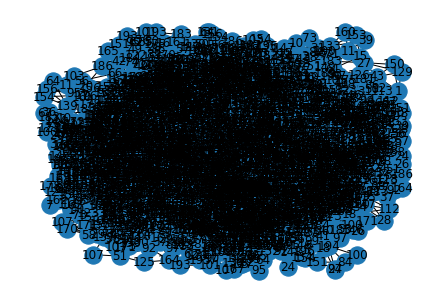

In [36]:
generate("../../Data/ground-truth","../../Data/graph_files")